This script is modified from https://github.com/theislab/scvelo_notebooks/blob/master/perspectives/Perspectives.ipynb


In [1]:
import numpy as np
import scvelo as scv
import torch
from deepvelo.utils.plot import parula_map
from deepvelo.utils import update_dict
from deepvelo.utils.preprocess import clip_and_norm_Ms_Mu, autoset_coeff_s
from deepvelo import Constants, train


%load_ext autoreload
%autoreload 2

scv.set_figure_params(dpi=100, fontsize=16, facecolor='none')
scv.settings.verbosity = 1  # set to 3 to see more information
scv.logging.print_version()

SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

Using backend: pytorch


Running scvelo 0.2.4 (python 3.7.3) on 2022-05-31 20:29.


ERROR: XMLRPC request failed [code: -32500]
RuntimeError: PyPI's XMLRPC API is currently disabled due to unmanageable load and will be deprecated in the near future. See https://status.python.org/ for more information.


# Direction reversal in hematopoiesis due to time-dependent rates

using cord blood CD34+ cells (unpublished data), where we obtain a direction reversal from what is biologically expected. Using simulated data, we show that reversed directions in the projected arrows can be explained by time-dependent degradation rates (Fig. 2d).

## Simulated data with time-dependent rates


In [2]:
# simulate data with constant rate
n_vars = 40
adata = scv.datasets.simulation(
    n_obs=500, n_vars=n_vars, t_max=25, alpha=5, beta=0.3, gamma=0.5, noise_level=0.8
)
scv.pp.pca(adata)
scv.tl.velocity(adata)

# simulate data with time-dep rate
n_obs = 500
alpha = [5] * n_vars
gamma = [0.5] * n_vars

# three genes with time-dependent rates
tnew = np.linspace(0.1, 5, num=n_obs)
gamma_t = 5 * (1 - np.exp(-0.3 * tnew))
for i in [0, 1, 5]:
    alpha[i] = 30
    gamma[i] = gamma_t

adata_t = scv.datasets.simulation(
    n_obs=n_obs,
    n_vars=n_vars,
    t_max=25,
    alpha=alpha,
    beta=0.3,
    gamma=gamma,
    noise_level=0.8,
)

scv.pp.moments(adata_t)
scv.tl.velocity(adata_t)


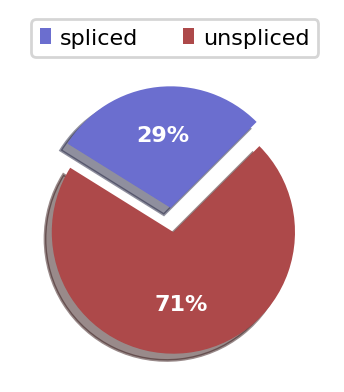

In [3]:
scv.pl.proportions(adata_t)


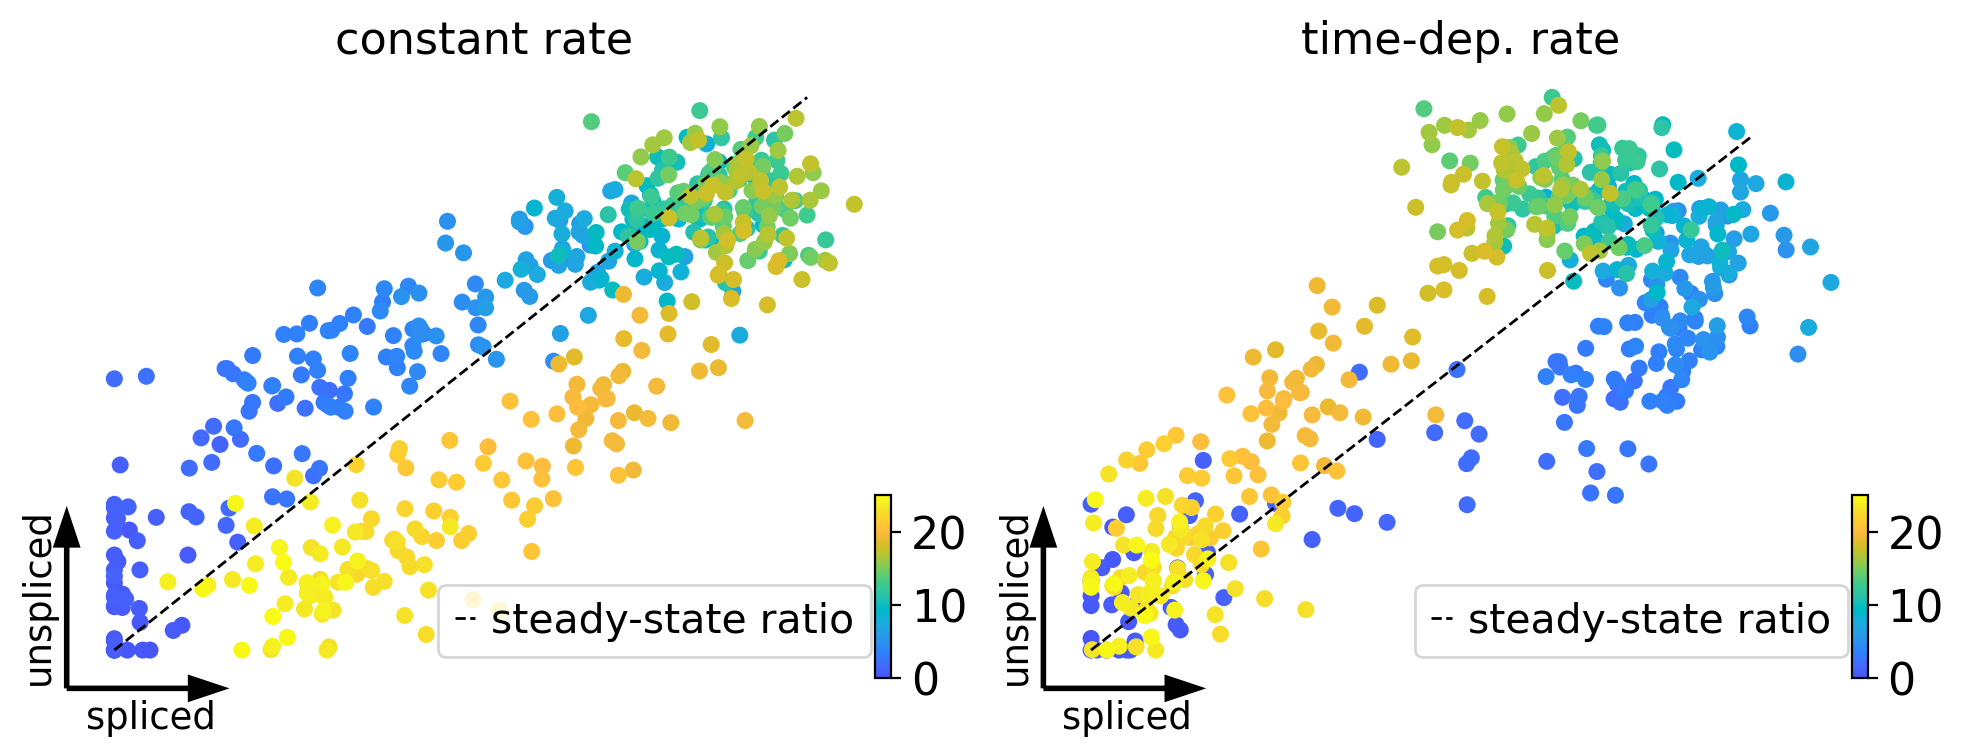

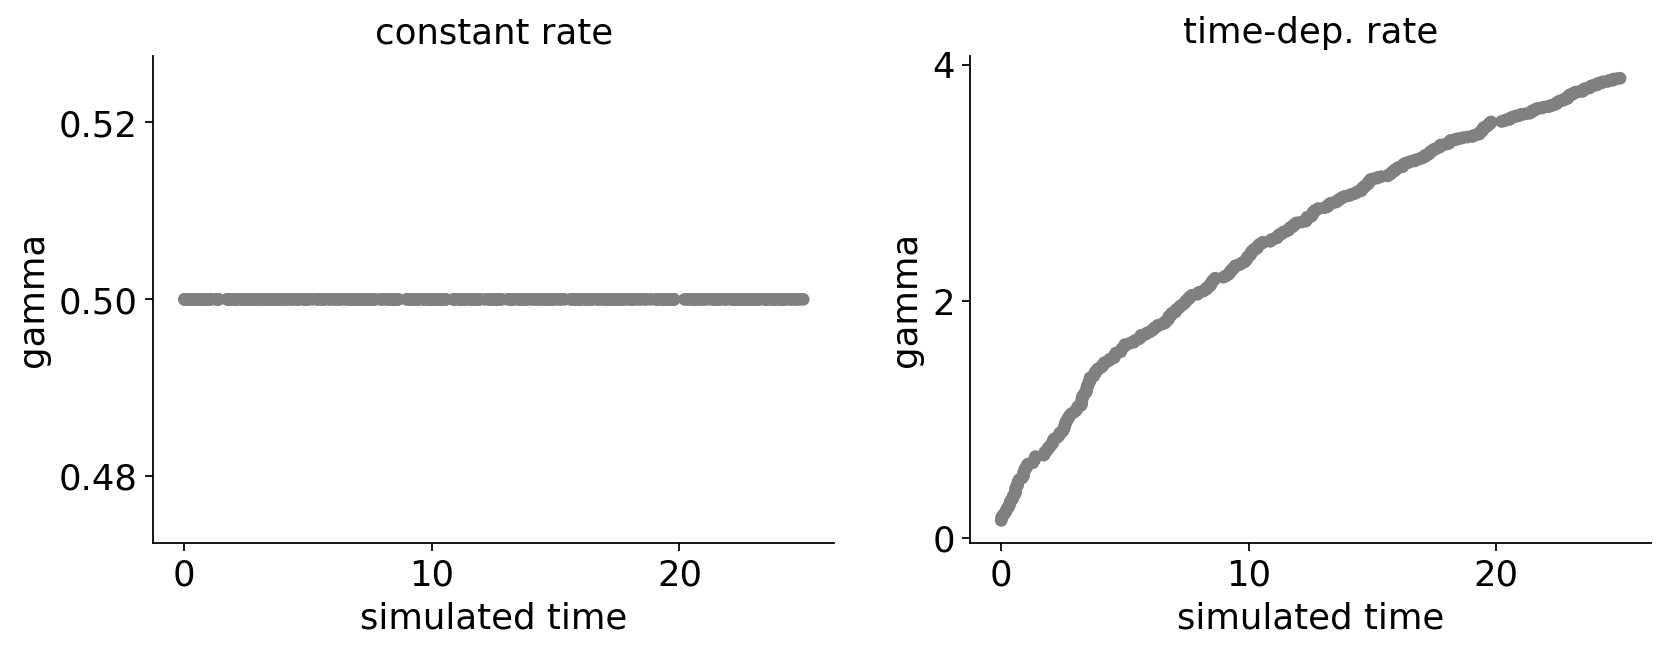

In [4]:
gs = scv.pl.gridspec()

kwargs = dict(
    c="true_t", cmap=parula_map, s=150, use_raw=True, frameon="artist", dpi=80
)
scv.pl.scatter(
    adata, basis=adata.var_names[5], ax=gs[0], title="constant rate", **kwargs
)
scv.pl.scatter(
    adata_t, basis=adata.var_names[5], ax=gs[1], title="time-dep. rate", **kwargs
)

adata_t.obs["gamma"] = 0.5
adata_t.obs["gamma_t"] = gamma_t
kwargs = dict(
    xlabel="simulated time", ylabel="gamma", title=["constant rate", "time-dep. rate"]
)
scv.pl.scatter(
    adata_t, x="true_t", y=["gamma", "gamma_t"], frameon="lb", dpi=80, **kwargs
)


  0%|          | 0/500 [00:00<?, ?cells/s]

  0%|          | 0/500 [00:00<?, ?cells/s]

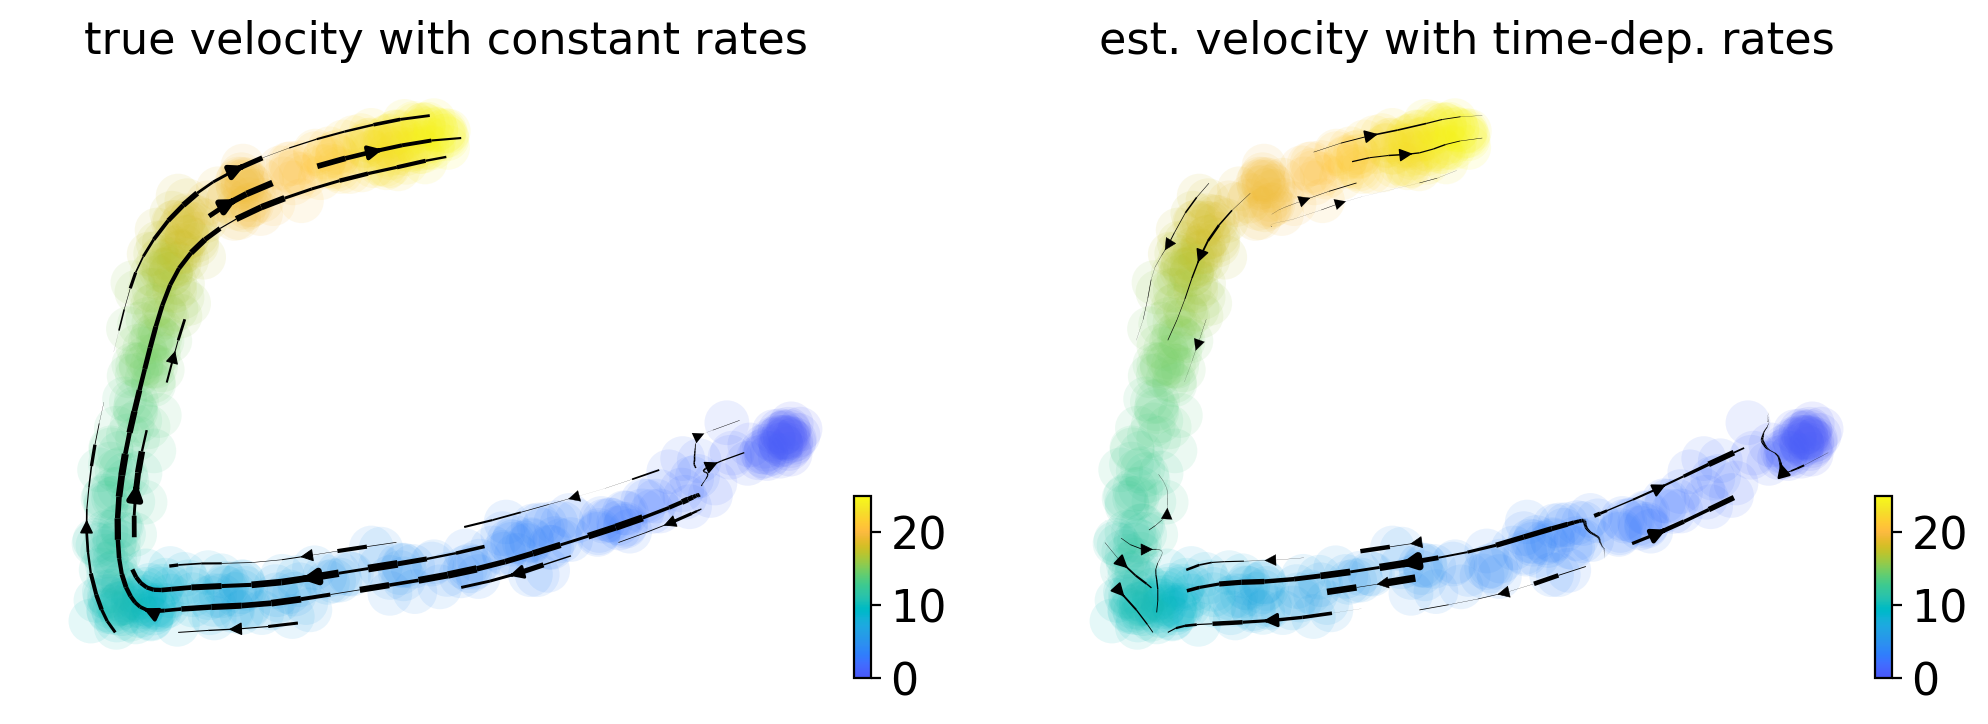

In [5]:
adata.var["velocity_genes"] = True
scv.tl.velocity_graph(adata)

adata_t.var["velocity_genes"] = True
scv.tl.velocity_graph(adata_t)

gs = scv.pl.gridspec(2)
adata_t.obsm["X_pca"] = adata.obsm["X_pca"]
kwargs = dict(
    linewidth=1.5,
    density=0.8,
    color="true_t",
    frameon=False,
    cmap=parula_map,
    add_margin=0.1,
    alpha=0.1,
)
scv.pl.velocity_embedding_stream(
    adata,
    basis="pca",
    show=False,
    title="true velocity with constant rates",
    **kwargs,
    ax=gs[0]
)
scv.pl.velocity_embedding_stream(
    adata_t, basis="pca", title="est. velocity with time-dep. rates", **kwargs, ax=gs[1]
)


## Test using DeepVelo


The ratio of spliced reads is 34.8% (less than 70%). Suggest using coeff_s 0.5.
Raw Ms: mean 4.86, max 14.03, std 3.89, 99.5% quantile 13.47 99.5% of non-zero: 13.47
Raw Mu: mean 11.95, max 101.19, std 17.12, 99.5% quantile 97.97 99.5% of non-zero: 97.97
Normalized Ms and Mu to mean of 0.4
New Ms: mean 0.40, max 1.15, std 0.32, 99.5% quantile 1.11
New Mu: mean 0.40, max 3.39, std 0.57, 99.5% quantile 3.28


INFO:train:Beginning training of DeepVelo ...
INFO:train:{'name': 'DeepVelo', 'n_gpu': 1, 'arch': {'type': 'VeloGCN', 'args': {'layers': [64, 64], 'dropout': 0.2, 'fc_layer': False, 'pred_unspliced': False, 'n_genes': 40}}, 'data_loader': {'type': 'VeloDataLoader', 'args': {'shuffle': False, 'validation_split': 0.0, 'num_workers': 2, 'type': 'pca, t', 'topC': 30, 'topG': 20, 'batch_size': 500}}, 'optimizer': {'type': 'Adam', 'args': {'lr': 0.001, 'weight_decay': 0, 'amsgrad': True}}, 'loss': {'type': 'mle_plus_direction', 'args': {'pearson_scale': 1.0, 'coeff_u': 1.0, 'coeff_s': 0.5}}, 'constraint_loss': False, 'mask_zeros': False, 'metrics': ['mse'], 'lr_scheduler': {'type': 'StepLR', 'args': {'step_size': 1, 'gamma': 0.97}}, 'trainer': {'epochs': 100, 'save_dir': 'saved/', 'save_period': 1000, 'verbosity': 0, 'monitor': 'min mse', 'early_stop': 1000, 'tensorboard': True}}
INFO:train:VeloGCN(
  (layers): ModuleList(
    (0): GraphConv(in=80, out=64, normalization=both, activation=<fun

building graph
velo data shape: torch.Size([500, 40])


building graph
velo data shape: torch.Size([500, 40])


  0%|          | 0/500 [00:00<?, ?cells/s]

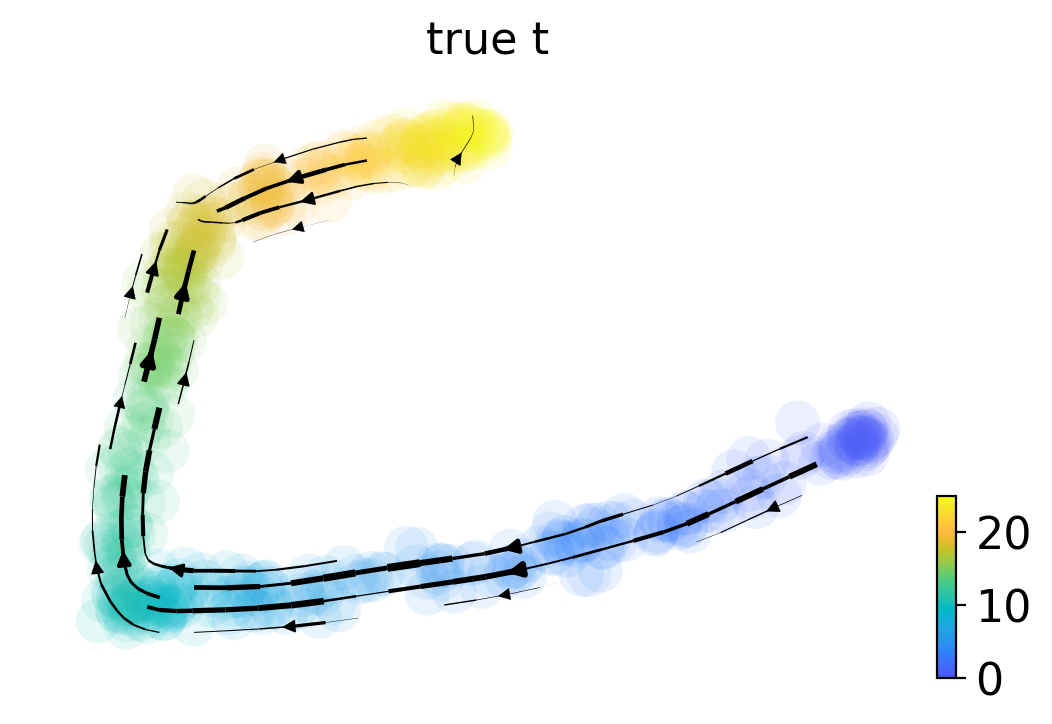

building graph
velo data shape: torch.Size([500, 40])


  0%|          | 0/500 [00:00<?, ?cells/s]

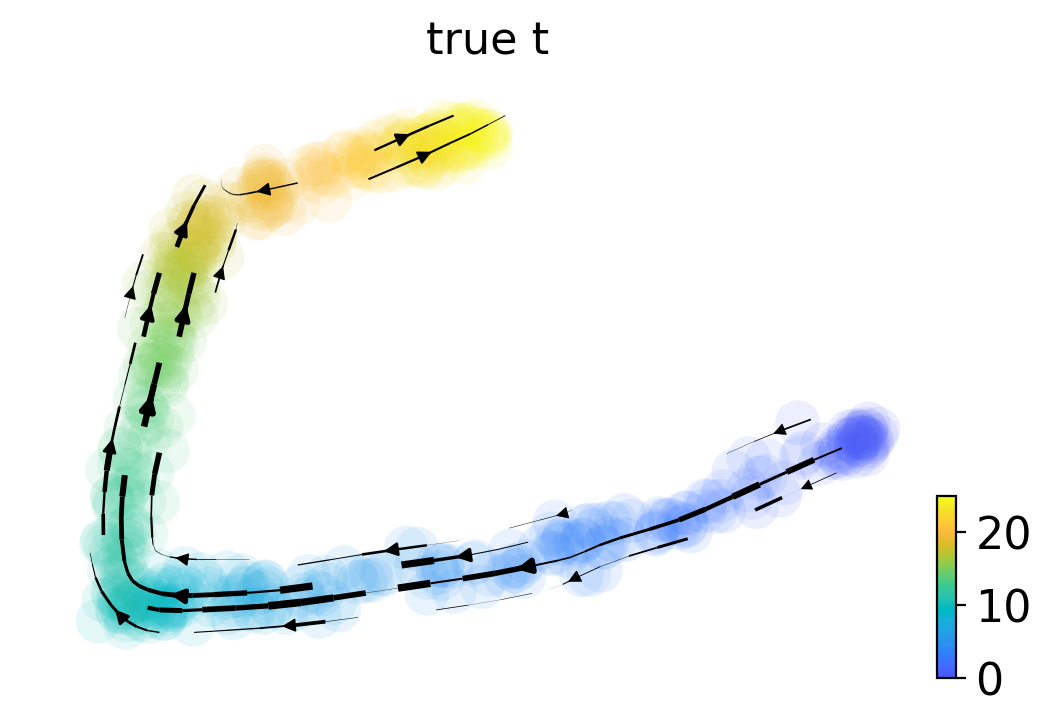

building graph
velo data shape: torch.Size([500, 40])


  0%|          | 0/500 [00:00<?, ?cells/s]

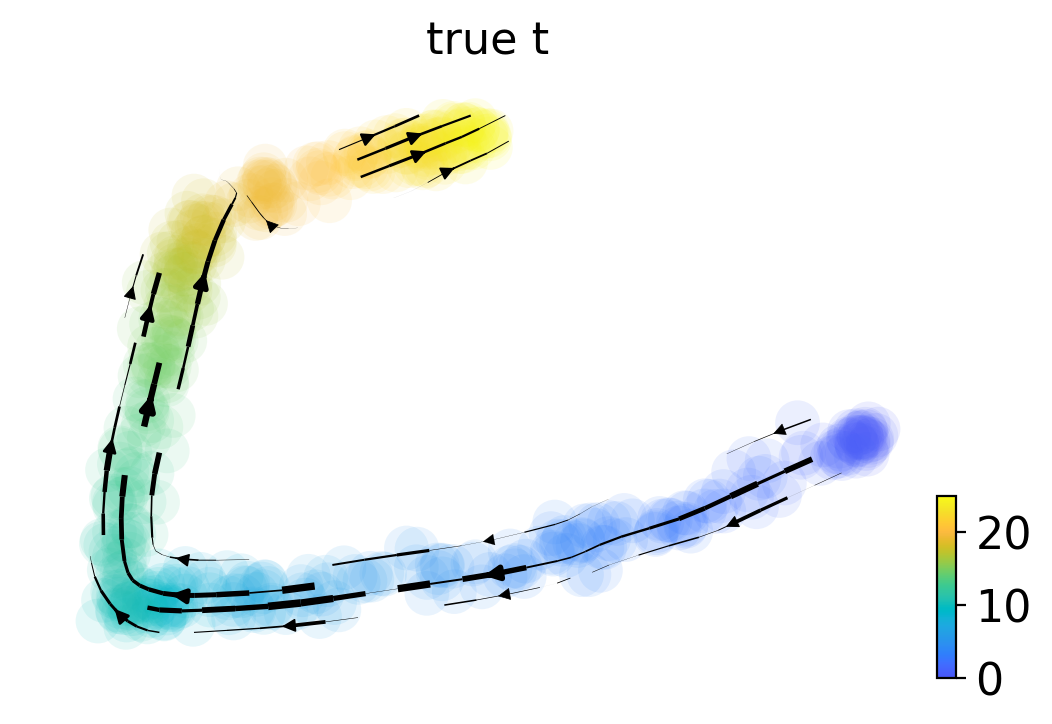

velo_mat shape: (500, 40)


  0%|          | 0/500 [00:00<?, ?cells/s]

In [6]:
# specific configs to overide the default configs
configs = {
    "name": "DeepVelo",
    "loss": {"args": {"pearson_scale": 1.0, "coeff_s": autoset_coeff_s(adata)}},
    "trainer": {"verbosity": 0},
}
configs = update_dict(Constants.default_configs, configs)

# normalize the input to stabilize the training
clip_and_norm_Ms_Mu(adata_t, do_clip=False, do_norm=True, replace=True, plot=False)


def eval_callback(ad, velo_mat, *args):
    ad.layers["velocity"] = velo_mat  # (cells, genes)
    scv.tl.velocity_graph(ad)
    scv.pl.velocity_embedding_stream(
        ad,
        basis="pca",
        **kwargs,
    )


# run on adata_t
trainer = train(adata_t, configs, verbose=True, callback=eval_callback)
scv.tl.velocity_graph(adata_t)


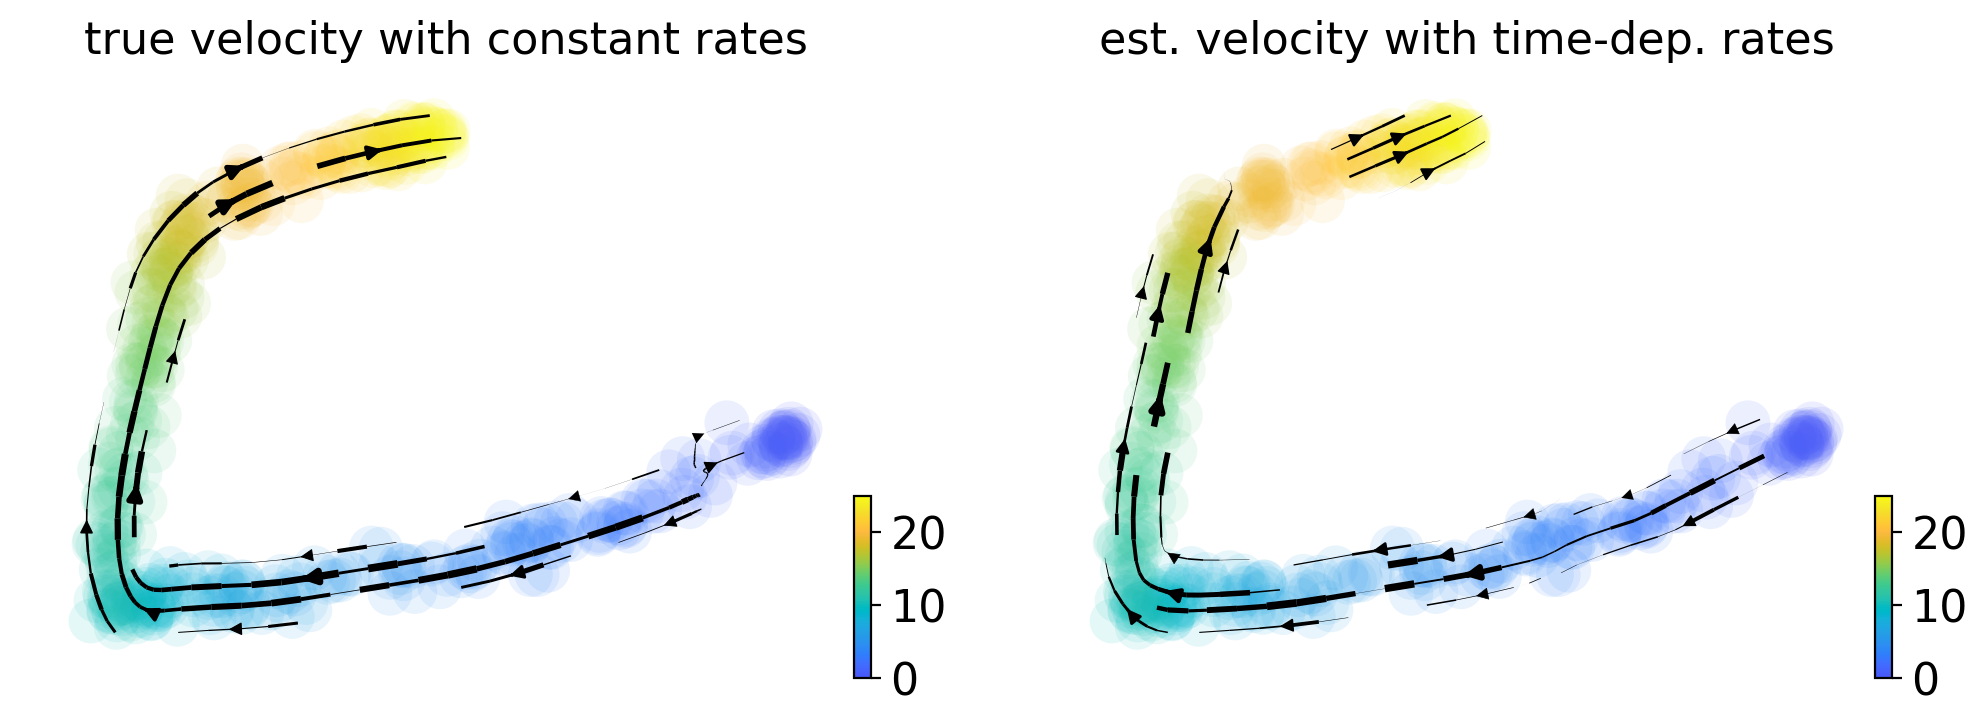

In [7]:
gs = scv.pl.gridspec(2)
scv.pl.velocity_embedding_stream(
    adata,
    basis="pca",
    show=False,
    title="true velocity with constant rates",
    **kwargs,
    ax=gs[0]
)
scv.pl.velocity_embedding_stream(
    adata_t, basis="pca", title="est. velocity with time-dep. rates", **kwargs, ax=gs[1]
)
